<a href="https://colab.research.google.com/github/alamwasim/job-a-thon/blob/main/JOB_A_THON_lgbm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install category_encoders
# !pip install bayesian-optimization
# !pip install scikit-optimize
# !pip install shap
# ! pip install neptune-client
# !pip install neptune-contrib

In [174]:
# !jupyter nbextension enable --py neptune-notebooks

Importing Libraries

In [3]:
from pandas_profiling import ProfileReport

#Encoding
import category_encoders as ce

#basic tools 
import os
import numpy as np
import pandas as pd
import pandas_profiling 
import scipy as sp
from scipy import stats
import warnings

#tuning hyperparameters
from bayes_opt import BayesianOptimization
import skopt
from skopt  import BayesSearchCV 

#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns

#building models
import lightgbm as lgb
# import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)

#Neptune
import neptune
import neptunecontrib.monitoring.skopt as sk_utils

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
PATH_OF_DATA= "/content/gdrive/MyDrive/ml_data/jobathon/"
!ls {PATH_OF_DATA}

jobathon_sample_submission.csv	jobathon_train.csv  lgbm_run2.csv
jobathon_test.csv		lgbm_run1.csv


In [110]:
train=pd.read_csv("/content/gdrive/MyDrive/ml_data/jobathon/jobathon_train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/ml_data/jobathon/jobathon_test.csv")

Setting Up Neptune Api

In [175]:
neptune.init(project_qualified_name='wasimalam/jobathon', # change this to your `workspace_name/project_name`
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNTEzYjQ1YzAtZWE4Yi00YzRkLTlmYWYtMmYwMmFiZjk3YTAyIn0=', # change this to your api token
            )

Project(wasimalam/jobathon)

In [89]:
train.shape,test.shape

((50882, 14), (21805, 13))

In [90]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

# Reduce Memory Usage Function

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Data Cleaning

Handling Missing Values

In [111]:
#Replacing Missing Values with 'null' string. These all wil be treated as categorical data
train[['Health Indicator','Holding_Policy_Type']]=train[['Health Indicator','Holding_Policy_Type']].fillna("null")
test[['Health Indicator','Holding_Policy_Type']]=test[['Health Indicator','Holding_Policy_Type']].fillna("null")
#Replacing Null with 0 in Holding policy Duration
train[['Holding_Policy_Duration']]=train[['Holding_Policy_Duration']].fillna(0)
test[['Holding_Policy_Duration']]=test[['Holding_Policy_Duration']].fillna(0)
#Replacing 14+ as 15 in Holding policy Duration
train.loc[train.Holding_Policy_Duration=='14+','Holding_Policy_Duration']=15
test.loc[test.Holding_Policy_Duration=='14+','Holding_Policy_Duration']=15

Creating New feature

In [112]:
#Creating new features 'Is_Holding_Policy' to indicate if particular ID holds any Policy or not base upon missing values in Holding Policy Type
train.loc[:,'Is_Holding_Policy']=1
train.loc[train.Holding_Policy_Type=="null",'Is_Holding_Policy']=0
test.loc[:,'Is_Holding_Policy']=1
test.loc[test.Holding_Policy_Type=="null",'Is_Holding_Policy']=0
#Creating new features 'mean_age' mean_age based upon lower and upper age
train.loc[:,'mean_age']=(train.Upper_Age+train.Lower_Age)/2
test.loc[:,'mean_age']=(test.Upper_Age+test.Lower_Age)/2
#Age Gap
train.loc[:,'age_gap']=train.Upper_Age-train.Lower_Age
test.loc[:,'age_gap']=test.Upper_Age-test.Lower_Age

In [113]:
def combine_two_cat(col1,col2):
  new_name=col1+"|"+col2
  train.loc[:,new_name]=train[col1].astype('str')+'|'+train[col2].astype('str')
  test.loc[:,new_name]=test[col1].astype('str')+'|'+test[col2].astype('str')

combine_two_cat('Holding_Policy_Type','Health Indicator')
combine_two_cat('Reco_Policy_Cat','Holding_Policy_Type')
combine_two_cat('Reco_Policy_Cat','Health Indicator')


In [117]:
def combine_three_cat(col1,col2,col3):
  new_name=col1+"|"+col2+"|"+col3
  train.loc[:,new_name]=train[col1].astype('str')+'|'+train[col2].astype('str')+'|'+train[col3].astype('str')
  test.loc[:,new_name]=test[col1].astype('str')+'|'+test[col2].astype('str')+'|'+test[col3].astype('str')

combine_three_cat('Accomodation_Type','Reco_Insurance_Type','Is_Spouse')

Binning of Categorical Columns

In [114]:
train['Health_Indicator_Grouped']=train['Health Indicator'].map({'X8':'G1','X9':'G1','X5':'G2','X6':'G2','X3':'G3','X4':'G3','X1':'G4','X2':'G4','X7':'G5','null':'G9'})
test['Health_Indicator_Grouped']=test['Health Indicator'].map({'X8':'G1','X9':'G1','X5':'G2','X6':'G2','X3':'G3','X4':'G3','X1':'G4','X2':'G4','X7':'G5','null':'G9'})
# train.groupby(['Health_Indicator_Grouped'])['Response'].agg(['mean','count'])

Target Encoding

In [115]:
#Target Encoding of City_Code and Region Code
te_cols=['City_Code','Region_Code','Reco_Policy_Cat','Holding_Policy_Duration','Health Indicator','Holding_Policy_Type']
te_cols_renamed=[x+"_te" for x in te_cols]
train[te_cols_renamed]=train[te_cols]
test[te_cols_renamed]=test[te_cols]
X_cols=[x for x in train.columns if x!='Response']
enc = ce.TargetEncoder(cols=te_cols_renamed,handle_unknown='value',smoothing=1,min_samples_leaf=1)
enc.fit(train[X_cols], train['Response'])
train[X_cols]=enc.transform(train[X_cols])
test[X_cols]=enc.transform(test[X_cols])

Lable Encoding

In [118]:
new_var_in_test=[]
new_var_in_train=[]
for c in train.select_dtypes('object').columns:
  new_var_in_test.append(len(set(test[c].values)-set(train[c].values)))
  new_var_in_train.append(len(set(train[c].values)-set(test[c].values)))
pd.DataFrame({'new_var_in_test':new_var_in_test,'new_var_in_train':new_var_in_train},index=train.select_dtypes('object').columns)


,new_var_in_test,new_var_in_train
City_Code,0,0
Accomodation_Type,0,0
Reco_Insurance_Type,0,0
Is_Spouse,0,0
Health Indicator,0,0
Holding_Policy_Duration,0,0
Holding_Policy_Type,0,0
Holding_Policy_Type|Health Indicator,0,0
Reco_Policy_Cat|Holding_Policy_Type,0,0
Reco_Policy_Cat|Health Indicator,1,13


In [119]:
train.Holding_Policy_Duration=train.Holding_Policy_Duration.astype('float32').astype('int32')
test.Holding_Policy_Duration=test.Holding_Policy_Duration.astype('float32').astype('int32')

In [120]:
le_col=['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type', 'Health_Indicator_Grouped',
        'Holding_Policy_Type|Health Indicator','Reco_Policy_Cat|Holding_Policy_Type','Reco_Policy_Cat|Health Indicator',
        'Accomodation_Type|Reco_Insurance_Type|Is_Spouse']
def le_fit(df,col):
  le_dict={}
  for c in col:
    le_dict[c]=dict(zip(train[c].unique(),range(train[c].nunique())))
  print("le_dict :",le_dict)
  return le_dict
def le_transform(df,col):
  for c in col:
    df[c]=df[c].map(le_dict[c],na_action='ignore').fillna(-1)
le_dict=le_fit(train,le_col)
le_transform(train,le_col)
le_transform(test,le_col)

le_dict : {'City_Code': {'C3': 0, 'C5': 1, 'C24': 2, 'C8': 3, 'C9': 4, 'C1': 5, 'C15': 6, 'C28': 7, 'C27': 8, 'C7': 9, 'C20': 10, 'C25': 11, 'C4': 12, 'C2': 13, 'C34': 14, 'C10': 15, 'C17': 16, 'C18': 17, 'C16': 18, 'C29': 19, 'C33': 20, 'C26': 21, 'C19': 22, 'C6': 23, 'C12': 24, 'C13': 25, 'C11': 26, 'C14': 27, 'C22': 28, 'C23': 29, 'C21': 30, 'C36': 31, 'C32': 32, 'C30': 33, 'C35': 34, 'C31': 35}, 'Accomodation_Type': {'Rented': 0, 'Owned': 1}, 'Reco_Insurance_Type': {'Individual': 0, 'Joint': 1}, 'Is_Spouse': {'No': 0, 'Yes': 1}, 'Health Indicator': {'X1': 0, 'X2': 1, 'null': 2, 'X4': 3, 'X3': 4, 'X6': 5, 'X5': 6, 'X8': 7, 'X7': 8, 'X9': 9}, 'Holding_Policy_Type': {3.0: 0, 'null': 1, 1.0: 2, 4.0: 3, 2.0: 4}, 'Health_Indicator_Grouped': {'G4': 0, 'G9': 1, 'G3': 2, 'G2': 3, 'G1': 4, 'G5': 5}, 'Holding_Policy_Type|Health Indicator': {'3.0|X1': 0, 'null|X2': 1, '1.0|null': 2, '1.0|X2': 3, 'null|null': 4, '4.0|X4': 5, '4.0|null': 6, '3.0|X3': 7, '2.0|null': 8, 'null|X3': 9, '1.0|X1': 10,

In [121]:
train.select_dtypes('object').columns

Index([], dtype='object')

# Correlation 

In [57]:
sns.heatmap(train.corr())

In [123]:
train.corr()['Response']

ID                                                 0.005159
City_Code                                          0.000322
Region_Code                                        0.001121
Accomodation_Type                                  0.005201
Reco_Insurance_Type                                0.009891
Upper_Age                                          0.002772
Lower_Age                                         -0.002099
Is_Spouse                                          0.003859
Health Indicator                                  -0.002636
Holding_Policy_Duration                            0.014125
Holding_Policy_Type                               -0.001077
Reco_Policy_Cat                                    0.114321
Reco_Policy_Premium                                0.007943
Response                                           1.000000
Is_Holding_Policy                                  0.001897
mean_age                                           0.000343
age_gap                                 

# Data Splitting and Column selection for model

In [124]:
train=reduce_mem_usage(train)

Mem. usage decreased to  1.99 Mb (81.4% reduction)


In [125]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response',
       'Is_Holding_Policy', 'mean_age', 'age_gap',
       'Holding_Policy_Type|Health Indicator',
       'Reco_Policy_Cat|Holding_Policy_Type',
       'Reco_Policy_Cat|Health Indicator', 'Health_Indicator_Grouped',
       'City_Code_te', 'Region_Code_te', 'Reco_Policy_Cat_te',
       'Holding_Policy_Duration_te', 'Health Indicator_te',
       'Holding_Policy_Type_te',
       'Accomodation_Type|Reco_Insurance_Type|Is_Spouse'],
      dtype='object')

In [127]:
sel_col=['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium',
        'mean_age','age_gap',
         'Holding_Policy_Type|Health Indicator','Reco_Policy_Cat|Holding_Policy_Type','Reco_Policy_Cat|Health Indicator','Accomodation_Type|Reco_Insurance_Type|Is_Spouse',
         'City_Code_te', 'Region_Code_te', 'Reco_Policy_Cat_te','Holding_Policy_Duration_te', 'Health Indicator_te','Holding_Policy_Type_te']
target_col=['Response']
binary_col=['Accomodation_Type','Reco_Insurance_Type', 'Is_Spouse']
nominal_col=['City_Code','Region_Code','Health Indicator', 'Holding_Policy_Type',
             'Holding_Policy_Type|Health Indicator','Reco_Policy_Cat|Holding_Policy_Type','Reco_Policy_Cat|Health Indicator','Accomodation_Type|Reco_Insurance_Type|Is_Spouse']
ordinal_col=['Holding_Policy_Duration','Upper_Age',]
# new_created_features=['Health_Indicator_Grouped','mean_age']
le_col=['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Type', 'Health_Indicator_Grouped']
categorical_features=binary_col+nominal_col+ordinal_col
numeric_features=[x for x in sel_col[:-1] if x not in categorical_features]
left_out_col=[x for x in train.columns if x not in sel_col]

print("left_out_col : ",left_out_col)
print("categorical_features : ",categorical_features)
print("numeric_features : ",numeric_features)

left_out_col :  ['ID', 'Lower_Age', 'Response', 'Is_Holding_Policy', 'Health_Indicator_Grouped']
categorical_features :  ['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'City_Code', 'Region_Code', 'Health Indicator', 'Holding_Policy_Type', 'Holding_Policy_Type|Health Indicator', 'Reco_Policy_Cat|Holding_Policy_Type', 'Reco_Policy_Cat|Health Indicator', 'Accomodation_Type|Reco_Insurance_Type|Is_Spouse', 'Holding_Policy_Duration', 'Upper_Age']
numeric_features :  ['Reco_Policy_Cat', 'Reco_Policy_Premium', 'mean_age', 'age_gap', 'City_Code_te', 'Region_Code_te', 'Reco_Policy_Cat_te', 'Holding_Policy_Duration_te', 'Health Indicator_te']


In [128]:
X, x_test, y, y_test = train_test_split(train[sel_col], train[target_col], test_size=0.2, random_state=786)
print(X.shape,x_test.shape,train.shape,X.shape[0]+x_test.shape[0])

(40705, 23) (10177, 23) (50882, 28) 50882


# Bayesian Tuning

Base Model

In [160]:
param = {'boosting':'dart','num_leaves': 31, 'objective': 'binary','max_cat_threshold':100,'cat_smooth':20,'cat_l2':80,'lambda_l1':5,'lambda_l2':5}
param['metric'] = 'auc'
num_round = 100
lgb_data = lgb.Dataset(data=X, label=y, free_raw_data=False,categorical_feature=categorical_features)
bst = lgb.train(param, lgb_data, num_round)
roc_auc_score(y_test,bst.predict(x_test))
# 0.657857226271536
# 0.7326535185543669
# 0.7510046775184535  'max_cat_threshold':100,'cat_smooth':20
# 0.7540892252952117 same as above +dart
# 0.7572543618964255 same as abve +'cat_l2':80

0.7558782498548139

In [175]:
%%time
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False,categorical_feature=categorical_features)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample,max_cat_threshold,cat_smooth,cat_l2,lambda_l1,lambda_l2):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_cat_threshold'] = int(round(max_cat_threshold))
        params['cat_smooth'] = max(min(cat_smooth, 1), 0)
        params['cat_l2'] = max(min(cat_l2, 1), 0)
        params['lambda_l1'] = max(min(cat_l2, 1), 0)
        params['lambda_l2'] = max(min(cat_l2, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0),
                                            'max_cat_threshold':(10,100),
                                            'cat_smooth':(5.0,30.0),
                                            'cat_l2':(5,100),
                                            'lambda_l1':(0,5),
                                            'lambda_l2':(0,5)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=50, opt_round=100, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... |  cat_l2   | cat_sm... | featur... | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_ca... | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7349   |  0.9895   |  26.52    |  19.86    |  0.4426   |  3.821    |  0.0143   |  0.3638   |  83.68    |  51.05    |  29.55    |  72.04    |  98.6     |  75.7     |  0.3107   |
|  2        |  0.7147   |  0.9692   |  16.52    |  24.64    |  0.3004   |  0.4801   |  4.717    |  0.8278   |  56.28    |  88.62    |  19.46    |  47.01    |  68.02    |  47.49    |  0.644    |
|  3        |  0.708    |  0.9217   |  15.02    |  29.15    |  0.707    |  3.398    |  1.647    |  0.03619  |  76.26    |  97.55    |  12.07    |  58.94    |  26.56    |  34.51    |  0.4249   |
|  4        |  0.7362   |  0.9

In [ ]:
a=opt_params
a

In [176]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['max_cat_threshold'] = int(round(opt_params[1]['max_cat_threshold']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.8003205754744556,
 'boost_from_average': False,
 'cat_l2': 8.64193288427023,
 'cat_smooth': 15.423632272090636,
 'feature_fraction': 0.21396950994853878,
 'is_unbalance': True,
 'lambda_l1': 1.6255073952211907,
 'lambda_l2': 0.10414742994484749,
 'learning_rate': 0.06367613777149862,
 'max_bin': 87,
 'max_cat_threshold': 10,
 'max_depth': 27,
 'metric': 'auc',
 'min_data_in_leaf': 73,
 'min_sum_hessian_in_leaf': 0.14787803192971571,
 'num_leaves': 45,
 'objective': 'binary',
 'subsample': 0.8902335639799182}

In [177]:
%%time
target= train[target_col]
features= sel_col


folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx],categorical_feature=categorical_features)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx],categorical_feature=categorical_features)

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[60]	training's auc: 0.79739	valid_1's auc: 0.759323
Fold 1
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[76]	training's auc: 0.803802	valid_1's auc: 0.747851
Fold 2
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[132]	training's auc: 0.819923	valid_1's auc: 0.744668
Fold 3
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[140]	training's auc: 0.820349	valid_1's auc: 0.757768
Fold 4
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[132]	training's auc: 0.819273	valid_1's auc: 0.759337
Fold 5
Training until validation scores don't improve for 250 rounds.
Early stopping, best iteration is:
[92]	training's auc: 0.808525	valid_1's auc: 0.747087
Fold 6
Training until validation scores don'

In [170]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance2.png')

In [83]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)
plt.savefig('shap.png')
plt.close()

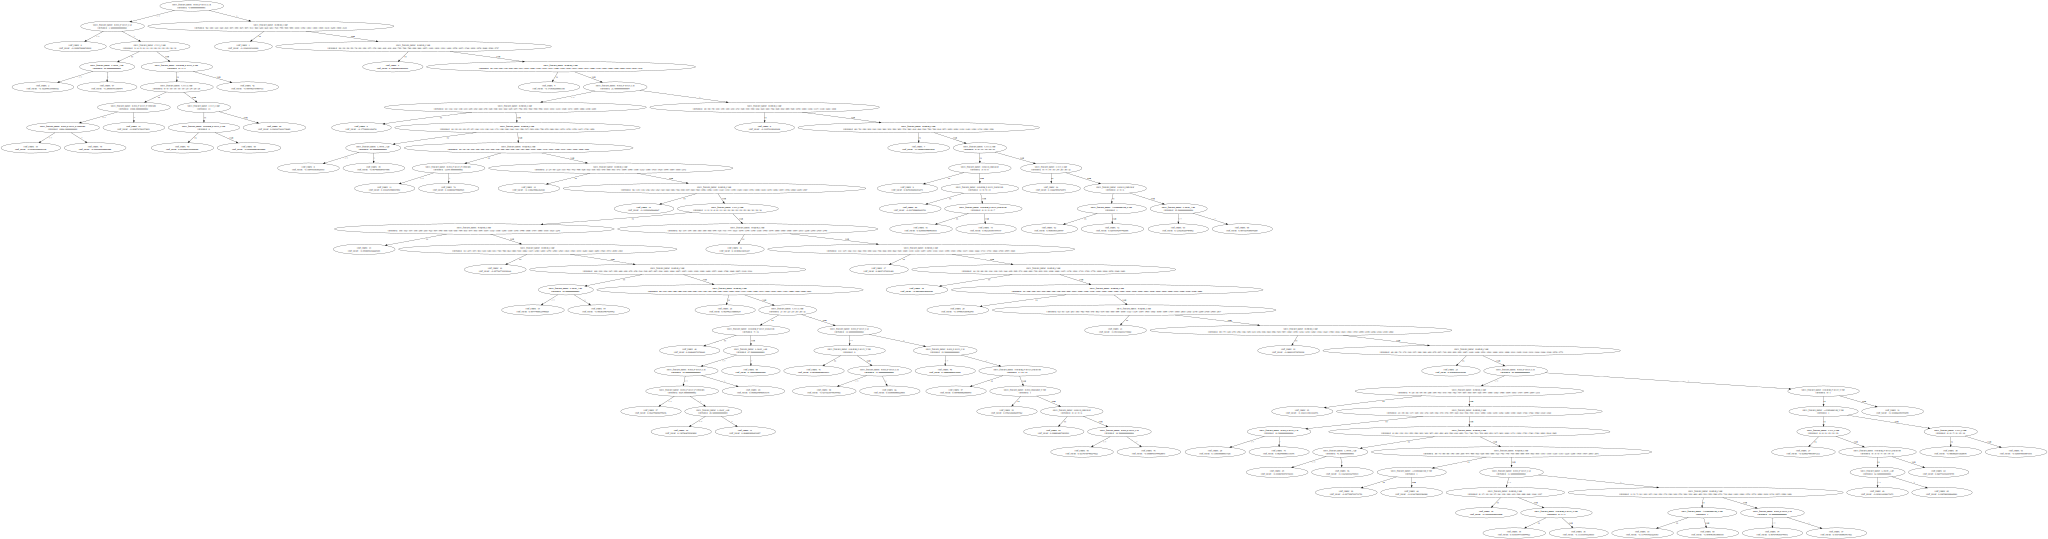

In [200]:
graph = lgb.create_tree_digraph(clf, tree_index=3, name='Tree3' )
graph.graph_attr.update(size="110,110")
with open('graph.svg', 'w') as f:
    f.write(graph._repr_svg_())
graph

# SKOPT Forest Minimize Tuning

In [193]:
SEARCH_PARAMS = {'learning_rate': 0.4,
                'max_depth': 15,
                'num_leaves': 32,
                'feature_fraction': 0.8,
                'subsample': 0.2}

FIXED_PARAMS={'objective': 'binary',
             'metric': 'auc',
             'is_unbalance':True,
             'bagging_freq':5,
             'boosting':'dart',
             'num_boost_round':300,
             'early_stopping_rounds':30}
SPACE = [
   skopt.space.Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
   skopt.space.Integer(1, 30, name='max_depth'),
   skopt.space.Integer(10, 200, name='num_leaves'),
   skopt.space.Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
   skopt.space.Real(0.1, 1.0, name='subsample', prior='uniform')
]

In [197]:

def train_evaluate(search_params):
   train_data = lgb.Dataset(X, label=y,free_raw_data=False,categorical_feature=categorical_features)
   valid_data = lgb.Dataset(x_test, label=y_test, reference=train_data,free_raw_data=False,categorical_feature=categorical_features)

   params = {'metric':FIXED_PARAMS['metric'],
             'objective':FIXED_PARAMS['objective'],
             **search_params}

   model = lgb.train(params, train_data,                     
                     valid_sets=[valid_data],
                     num_boost_round=FIXED_PARAMS['num_boost_round'],
                     early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
                     valid_names=['valid'])
   score = model.best_score['valid']['auc']
   return score

In [198]:
neptune.init('wasimalam/jobathon',api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNTEzYjQ1YzAtZWE4Yi00YzRkLTlmYWYtMmYwMmFiZjk3YTAyIn0=')
neptune.create_experiment('lgb-tuning_2', upload_source_files=['*.*'],
                              tags=['lgb-tuning', 'dart'],params=SEARCH_PARAMS)

@skopt.utils.use_named_args(SPACE)
def objective(**params):
   return -1.0 * train_evaluate(params)

monitor = sk_utils.NeptuneMonitor()
results = skopt.forest_minimize(objective, SPACE, 
                                n_calls=100, n_random_starts=10, 
                                callback=[monitor])
sk_utils.log_results(results)

neptune.stop()

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


Streaming output truncated to the last 5000 lines.
[195]	valid's auc: 0.667061
[196]	valid's auc: 0.666857
[197]	valid's auc: 0.666643
[198]	valid's auc: 0.666569
[199]	valid's auc: 0.6664
[200]	valid's auc: 0.666279
[201]	valid's auc: 0.666211
[202]	valid's auc: 0.666181
[203]	valid's auc: 0.666209
[204]	valid's auc: 0.665979
[205]	valid's auc: 0.6659
[206]	valid's auc: 0.666141
[207]	valid's auc: 0.666198
[208]	valid's auc: 0.666413
[209]	valid's auc: 0.66628
[210]	valid's auc: 0.66629
[211]	valid's auc: 0.666443
[212]	valid's auc: 0.666665
[213]	valid's auc: 0.666593
[214]	valid's auc: 0.666722
[215]	valid's auc: 0.666617
[216]	valid's auc: 0.667046
[217]	valid's auc: 0.667235
[218]	valid's auc: 0.667404
[219]	valid's auc: 0.667694
[220]	valid's auc: 0.667834
[221]	valid's auc: 0.667972
[222]	valid's auc: 0.668426
[223]	valid's auc: 0.668929
[224]	valid's auc: 0.668932
[225]	valid's auc: 0.669281
[226]	valid's auc: 0.669701
[227]	valid's auc: 0.670024
[228]	valid's auc: 0.669818
[22

In [221]:
opt_params=dict(zip(SEARCH_PARAMS.keys(),results['x']))
opt_params.update(FIXED_PARAMS)
opt_params

{'bagging_freq': 5,
 'boosting': 'dart',
 'early_stopping_rounds': 30,
 'feature_fraction': 0.9832690005479213,
 'is_unbalance': True,
 'learning_rate': 0.11012490724473883,
 'max_depth': 5,
 'metric': 'auc',
 'num_boost_round': 300,
 'num_leaves': 172,
 'objective': 'binary',
 'subsample': 0.7308738085025042}

In [ ]:
{'bagging_fraction': 0.8056841793158674,
 'boost_from_average': False,
 'feature_fraction': 0.7950165069530923,
 'is_unbalance': True,
 'learning_rate': 0.1438811218065178,
 'max_bin': 90,
 'max_depth': 26,
 'metric': 'auc',
 'min_data_in_leaf': 21,
 'min_sum_hessian_in_leaf': 76.87391409946883,
 'num_leaves': 79,
 'objective': 'binary',
 'subsample': 0.7720388533514295}

In [230]:
print("Best AUC SCORE :" ,-1*results['fun'])

Best AUC SCORE : 0.6751231451945494


# Final Summary Preparation and Model training on optimize parametre

Training Model with optimize parametre on X

In [178]:
num_round = 10000
lgb_data = lgb.Dataset(data=X, label=y, free_raw_data=False,categorical_feature=categorical_features)
bst = lgb.train(opt_params, lgb_data, num_round)
roc_auc_score(y_test,bst.predict(x_test))

0.7186150189794046

Training Model with optemize paramtere on all train dataset

In [179]:
num_round = 10000
lgb_data = lgb.Dataset(data=train[sel_col], label=train[target_col], free_raw_data=False,categorical_feature=categorical_features)
bst = lgb.train(opt_params, lgb_data, num_round)
roc_auc_score(y_test,bst.predict(x_test))

0.9998073127519717

generating submission file

In [173]:
pred=bst.predict(test[sel_col])

In [180]:
submission=pd.DataFrame({'ID':test.ID,'Response':pred})
submission.to_csv("/content/gdrive/MyDrive/ml_data/jobathon/lgbm_run4_v2.csv",index=False)

# NN